# Description of the _Python_ library `ncbc`

The library can be installed in development mode using the instruction in the `README` file in this repository. After installation, the package is imported as a standard *python* library:

In [1]:
import ncbc

Data can be simulated using the function `simulate_data`. The arguments are identical to the notation used in the paper _"Unsupervised attack pattern detection in honeypot data using Bayesian topic modelling"_. 

In [2]:
x = ncbc.simulate_data(D=200, K=2, gamma=5, H=4, eta=0.25, 
                command_level_topics=True, secondary_topic=True, 
                V=50, tau=0.5, csi=10, omega=5, alpha=10, alpha0=1, seed=171)

The output `x` is a dictionary containing the corpus `w`, the latent allocations `t`, `s` and `z`, and the parameters `phi`, `psi` and `theta` used to simulate the documents.

In [3]:
list(x.keys())

['t', 'N', 'M', 'w', 'lambda', 'phi', 's', 'psi', 'z', 'theta']

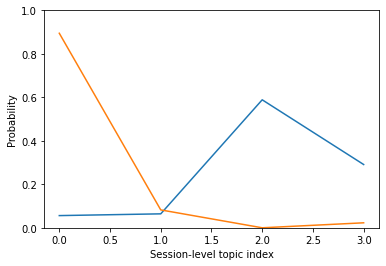

In [4]:
import matplotlib.pyplot as plt
for h in x['psi']:
    plt.plot(x['psi'][h])
plt.ylabel('Probability'); plt.xlabel('Session-level topic index'); plt.ylim((0,1))
plt.show()

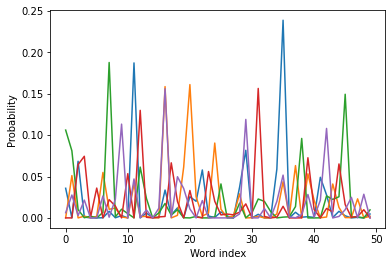

In [5]:
import matplotlib.pyplot as plt
for h in x['phi']:
    plt.plot(x['phi'][h])
plt.ylabel('Probability'); plt.xlabel('Word index'); 
plt.show()

The main object in the library `lda_clust` is the class `topic_model`, which is used to fit the models discussed in the paper. The main argument of the class is a dictionary of dictionaries `W`, containing the sessions and commands. Note that the parameters `K`, `H` and `V` have an option to be considered *not fixed*, corresponding to the Dirichlet process extension discussed in the paper, using the additional options `lambda_gem=True`, `psi_gem=True`, `phi_gem=True`.

In [6]:
m = ncbc.topic_model(W=x['w'], K=2, V=0, fixed_V=True, secondary_topic=True, 
            command_level_topics=True, H=5, gamma=5, eta=0.25, alpha=10)

Next, the model must be initialised. Four options have been implemented:
- `custom_init`, which takes `t`, `s` and `z` as arguments (when required), initialising the model from pre-specified values (this is mainly useful for testing, for example when the model is initialised from the truth on simulated data);
- `random_init`, which initialises `t`, `s` and `z` at random;
- `gensim_init`, which uses `gensim` to initialise the parameters. More details about this initialisation strategy are given in the paper;
- `spectral_init`, which uses *spectral clustering* to initialise the parameters. More details about this initialisation strategy are given in the paper. 

Initialising the model is simple, since the functions *do not require arguments*, except `custom_init`:

In [7]:
import numpy as np
z = {}
for d in m.w:
    z[d] = {}
    for j in m.w[d]:
        z[d][j] = np.random.choice(2,size=m.M[d][j])

## Initialise t and s to the truth and z to random values
m.custom_init(t=x['t'], s=x['s'], z=z)

## Initialise at random
m.random_init()

## Initialise using spectral clustering
m.spectral_init()

Note that `spectral_init` has also an option to initialise to values diffenent from the values of `K` and `H` pre-specified in `topic_model`.

Next, the Metropolis-within-Gibbs algorithm described in the paper could be run from the `topic_model` object to make inference on the topic allocations. The corresponding function of `topic_model` is `MCMC`, which takes multiple arguments:
- `iterations`, corresponding to the number of iterations after a burnin period;
- `burnin`, corresponding to the lenght of the of burnin period;
- `size`, corresponding to the number of session-level topic, command-level topic or topic indicators to resample whenever the corresponding Gibbs sampling move is performed (default is `1`);
- `calculate_ll`, a boolean variable (default `True`) used to return the marginal posterior (up to proportionality);
- `verbose`, a boolean variable, which is used to display a progress bar when `True`;
- `random_allocation`, a boolean variable (default `False`). If `True`, the sessions or commands are allocated at random to topics when proposing the split-merge move. Otherwise, the method described in the paper (default) is used. 

In [8]:
ll = m.MCMC(iterations=25000,burnin=10000,size=50,verbose=True,
            calculate_ll=True,random_allocation=False,jupy_out=True)

'Progression: 25000 / 25000'

Plot of the marginal posterior after the burnin period:

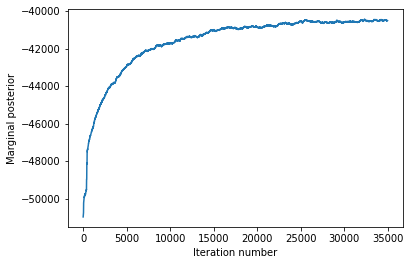

In [9]:
plt.plot(ll['loglik']); plt.ylabel('Marginal likelihood'); plt.xlabel('Iteration number'); plt.show()

It is also possible to use the adjusted Rand index (ARI) to evaluate the performance in estimating the session-level and command-level topics: 

In [10]:
ncbc.ari_t(x['t'], m.t)

1.0

In [11]:
ncbc.ari_s(x['s'], m.s, crosstab_out=False)

1.0

Similarly, a score can be calculated for the estimates of the topic indicators:

In [12]:
ncbc.F1_Z(x['z'], m.z)

(0.9364507411350421,
 col_0   0.0    1.0
 row_0             
 0       189    453
 1      1099  11435)